# I. Importing libraries and dataset 

In [54]:
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import pickle
import numpy as np
import stat
from sklearn import linear_model
import matplotlib.pyplot as plt 
from src import LogisticRegression_with_p_values, create_summary_table

In [55]:
loaded_model = pickle.load(open('pd_model.sav', 'rb'))  

In [56]:
feature_list = pickle.load(open('feature_list', 'rb'))
ref_categories = pickle.load(open('ref_categories', 'rb'))

In [57]:
loan_data_inputs_train = pd.read_csv('X_train.csv', index_col = 0)
loan_data_targets_train = pd.read_csv('y_train.csv', index_col = 0)
loan_data_inputs_test = pd.read_csv('X_test.csv', index_col = 0)
loan_data_targets_test = pd.read_csv('y_test.csv', index_col = 0)

In [58]:
inputs_train_with_ref_cat = loan_data_inputs_train.loc[: , feature_list]
inputs_test_with_ref_cat = loan_data_inputs_test.loc[: , feature_list]

In [59]:
feature_name = loan_data_targets_train.columns.values
summary_table = create_summary_table(loaded_model)

# I. Creating a Scorecard

- Turning PD models into simplified model versions called scorecards.
- A scorecard tool produces an individual credit worthiness assessment that directly corresponds to a specific probability of default.

Taking reference category as zero

In [60]:
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
df_ref_categories['Coefficients'] = 0
df_ref_categories['p-values'] = np.nan
df_ref_categories

,Feature name,Coefficients,p-values
0,grade:G,0,NaN
1,home_ownership:RENT_OTHER_NONE_ANY,0,NaN
2,addr_state:ND_NE_IA,0,NaN
3,verification_status:Verified,0,NaN
4,purpose:educ__sm_b_mov,0,NaN
5,initial_list_status:f,0,NaN
6,term:60,0,NaN
7,emp_length:0,0,NaN
8,mths_since_issue_d:>84,0,NaN
9,int_rate:>20.281,0,NaN


In [61]:
df_scorecard = pd.concat([summary_table, df_ref_categories])
df_scorecard = df_scorecard.reset_index()
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard

,index,Feature name,Coefficients,p-values,Original feature name
0,0,Intercept,-0.262363,NaN,Intercept
1,1,grade:A,1.021790,0.000000,grade
2,2,grade:B,0.769305,0.000000,grade
3,3,grade:C,0.556755,0.000000,grade
4,4,grade:D,0.367827,0.000000,grade
...,...,...,...,...,...
93,10,total_acc:<15.0,0.000000,NaN,total_acc
94,11,annual_inc:<20K,0.000000,NaN,annual_inc
95,12,dti:>30.392,0.000000,NaN,dti
96,13,mths_since_last_delinq:0-3,0.000000,NaN,mths_since_last_delinq


Set the scorecard range to match the common FICO scale, with a minimum score of 300 and a maximum score of 850.

In [62]:
min_score = 300
max_score = 850

In [63]:
df_scorecard.groupby('Original feature name')['Coefficients'].min()

Original feature name
Intercept                -0.262363
addr_state               -0.065610
annual_inc               -0.201223
dti                      -0.080457
emp_length               -0.005466
grade                     0.000000
home_ownership            0.000000
initial_list_status       0.000000
int_rate                  0.000000
mths_since_issue_d        0.000000
mths_since_last_delinq    0.000000
mths_since_last_record   -0.046861
purpose                   0.000000
term                      0.000000
total_acc                -0.072807
verification_status      -0.021147
Name: Coefficients, dtype: float64

In [64]:
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
min_sum_coef

-0.7559346425703328

In [65]:
df_scorecard.groupby('Original feature name')['Coefficients'].max()

Original feature name
Intercept                -0.262363
addr_state                0.413865
annual_inc                0.482574
dti                       0.227461
emp_length                0.063938
grade                     1.021790
home_ownership            0.103030
initial_list_status       0.048918
int_rate                  1.012118
mths_since_issue_d        1.199366
mths_since_last_delinq    0.100329
mths_since_last_record    0.387769
purpose                   0.422038
term                      0.037016
total_acc                 0.107598
verification_status       0.083122
Name: Coefficients, dtype: float64

In [66]:
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
max_sum_coef

5.448568456249347

Rescale the sum of coefficients to the predefined score range (min_score to max_score).

In [67]:
df_scorecard['Score'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
df_scorecard

,index,Feature name,Coefficients,p-values,Original feature name,Score
0,0,Intercept,-0.262363,NaN,Intercept,-23.257277
1,1,grade:A,1.021790,0.000000,grade,90.576840
2,2,grade:B,0.769305,0.000000,grade,68.195299
3,3,grade:C,0.556755,0.000000,grade,49.353727
4,4,grade:D,0.367827,0.000000,grade,32.606155
...,...,...,...,...,...,...
93,10,total_acc:<15.0,0.000000,NaN,total_acc,0.000000
94,11,annual_inc:<20K,0.000000,NaN,annual_inc,0.000000
95,12,dti:>30.392,0.000000,NaN,dti,0.000000
96,13,mths_since_last_delinq:0-3,0.000000,NaN,mths_since_last_delinq,0.000000


In [68]:
df_scorecard['Score'][0] = ((df_scorecard['Coefficients'][0] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
df_scorecard

C:\Users\PC\AppData\Local\Temp\ipykernel_13576\3303885477.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scorecard['Score'][0] = ((df_scorecard['Coefficients'][0] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score


,index,Feature name,Coefficients,p-values,Original feature name,Score
0,0,Intercept,-0.262363,NaN,Intercept,343.752771
1,1,grade:A,1.021790,0.000000,grade,90.576840
2,2,grade:B,0.769305,0.000000,grade,68.195299
3,3,grade:C,0.556755,0.000000,grade,49.353727
4,4,grade:D,0.367827,0.000000,grade,32.606155
...,...,...,...,...,...,...
93,10,total_acc:<15.0,0.000000,NaN,total_acc,0.000000
94,11,annual_inc:<20K,0.000000,NaN,annual_inc,0.000000
95,12,dti:>30.392,0.000000,NaN,dti,0.000000
96,13,mths_since_last_delinq:0-3,0.000000,NaN,mths_since_last_delinq,0.000000


In [69]:
df_scorecard['Score'] = df_scorecard['Score'].round()
df_scorecard

,index,Feature name,Coefficients,p-values,Original feature name,Score
0,0,Intercept,-0.262363,NaN,Intercept,344.0
1,1,grade:A,1.021790,0.000000,grade,91.0
2,2,grade:B,0.769305,0.000000,grade,68.0
3,3,grade:C,0.556755,0.000000,grade,49.0
4,4,grade:D,0.367827,0.000000,grade,33.0
...,...,...,...,...,...,...
93,10,total_acc:<15.0,0.000000,NaN,total_acc,0.0
94,11,annual_inc:<20K,0.000000,NaN,annual_inc,0.0
95,12,dti:>30.392,0.000000,NaN,dti,0.0
96,13,mths_since_last_delinq:0-3,0.000000,NaN,mths_since_last_delinq,0.0


In [70]:
min_sum_score_final = df_scorecard.groupby('Original feature name')['Score'].min().sum()
min_sum_score_final

301.0

In [71]:
max_sum_score_final = df_scorecard.groupby('Original feature name')['Score'].max(). sum()
max_sum_score_final

850.0

### Caclulating Credit Score

In [72]:
inputs_test_with_ref_cat.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,home_ownership:MORTGAGE,...,mths_since_last_record:<=2.42,mths_since_last_record:2.42-38.72,mths_since_last_record:38.72-48.4,mths_since_last_record:48.4-62.92,mths_since_last_record:62.92-65.34,mths_since_last_record:65.34-77.44,mths_since_last_record:77.44-82.28,mths_since_last_record:82.28-94.38,mths_since_last_record:94.38-106.48,mths_since_last_record:>106.48
362514,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
288564,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
213591,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
263083,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
165001,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [73]:
df_scorecard

,index,Feature name,Coefficients,p-values,Original feature name,Score
0,0,Intercept,-0.262363,NaN,Intercept,344.0
1,1,grade:A,1.021790,0.000000,grade,91.0
2,2,grade:B,0.769305,0.000000,grade,68.0
3,3,grade:C,0.556755,0.000000,grade,49.0
4,4,grade:D,0.367827,0.000000,grade,33.0
...,...,...,...,...,...,...
93,10,total_acc:<15.0,0.000000,NaN,total_acc,0.0
94,11,annual_inc:<20K,0.000000,NaN,annual_inc,0.0
95,12,dti:>30.392,0.000000,NaN,dti,0.0
96,13,mths_since_last_delinq:0-3,0.000000,NaN,mths_since_last_delinq,0.0


In [74]:
inputs_test_with_ref_cat_w_intercept = inputs_test_with_ref_cat
inputs_test_with_ref_cat_w_intercept.insert(0, 'Intercept', 1)
inputs_test_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,...,mths_since_last_record:<=2.42,mths_since_last_record:2.42-38.72,mths_since_last_record:38.72-48.4,mths_since_last_record:48.4-62.92,mths_since_last_record:62.92-65.34,mths_since_last_record:65.34-77.44,mths_since_last_record:77.44-82.28,mths_since_last_record:82.28-94.38,mths_since_last_record:94.38-106.48,mths_since_last_record:>106.48
362514,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
288564,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
213591,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263083,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
165001,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
inputs_test_with_ref_cat_w_intercept = inputs_test_with_ref_cat_w_intercept[df_scorecard['Feature name'].values]
inputs_test_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NV_FL_HI_AL,...,initial_list_status:f,term:60,emp_length:0,mths_since_issue_d:>84,int_rate:>20.281,total_acc:<15.0,annual_inc:<20K,dti:>30.392,mths_since_last_delinq:0-3,mths_since_last_record:<=2.42
362514,1,0,0,1,0,0,0,0,1,0,...,1,1,1,0,0,0,0,0,0,0
288564,1,0,0,0,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
213591,1,0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
263083,1,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
165001,1,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [76]:
scorecard_scores = df_scorecard['Score']

In [77]:
scorecard_scores.shape

(98,)

In [78]:
scorecard_scores = scorecard_scores.values.reshape(98, 1)
scorecard_scores.shape

(98, 1)

Dot product to calculate credit score of individual

In [79]:
y_scores = inputs_test_with_ref_cat_w_intercept.dot(scorecard_scores)
y_scores.head()

,0
362514,587.0
288564,515.0
213591,539.0
263083,608.0
165001,661.0


### Setting Cut-offs

The cutoff rate determines loan approval, balancing approval volume and borrower quality: lowering it increases accepted loans but raises risk, while raising it limits approvals to only the most creditworthy.

In [80]:
inputs_test = inputs_test_with_ref_cat.drop(ref_categories, axis = 1)
inputs_test.drop('Intercept',axis=1, inplace=True)

In [81]:
y_hat_test_proba = loaded_model.model.predict_proba(inputs_test)
y_hat_test_proba = y_hat_test_proba[: ][: , 1]
y_hat_test_proba

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


array([0.92374894, 0.84439152, 0.87583998, ..., 0.96878815, 0.95560428,
       0.94755077])

In [82]:
loan_data_targets_test_temp = loan_data_targets_test
loan_data_targets_test_temp.reset_index(drop = True, inplace = True)
df_actual_predicted_probs = pd.concat([loan_data_targets_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
df_actual_predicted_probs.columns = ['loan_data_targets_test', 'y_hat_test_proba']
df_actual_predicted_probs.index = loan_data_inputs_test.index

In [87]:
roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])

(array([0.        , 0.        , 0.        , ..., 0.99990186, 0.99990186,
        1.        ]),
 array([0.00000000e+00, 1.20384750e-05, 1.08346275e-04, ...,
        9.99987962e-01, 1.00000000e+00, 1.00000000e+00]),
 array([       inf, 0.99124965, 0.99021688, ..., 0.48587235, 0.48471751,
        0.44530384]))

In [88]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])

Text(0.5, 1.0, 'ROC curve')

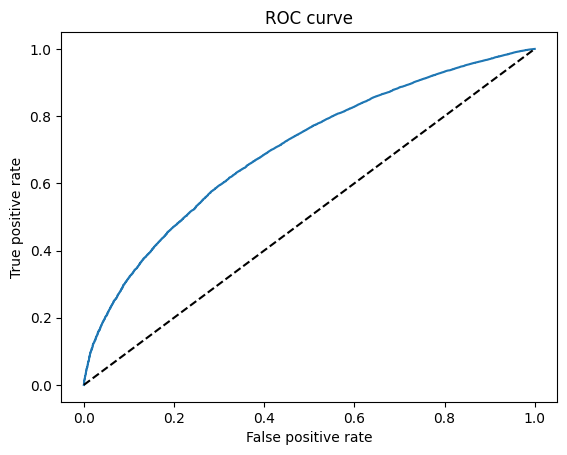

In [89]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

Table of classification thresholds with corresponding false positive and true positive rates.

In [90]:
df_cutoffs = pd.concat([pd.DataFrame(thresholds), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis = 1)
df_cutoffs.columns = ['thresholds', 'fpr', 'tpr']
df_cutoffs.head()

,thresholds,fpr,tpr
0,inf,0.000000,0.000000
1,0.991250,0.000000,0.000012
2,0.990217,0.000000,0.000108
3,0.990171,0.000098,0.000108
4,0.989329,0.000098,0.000373


Set the maximum thresholds to 1 

In [91]:
df_cutoffs['thresholds'][0] = 1 - 1 / np.power(10, 16)

In [92]:
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()
df_cutoffs.head()

,thresholds,fpr,tpr,Score
0,1.000000,0.000000,0.000000,2260.0
1,0.991250,0.000000,0.000012,786.0
2,0.990217,0.000000,0.000108,776.0
3,0.990171,0.000098,0.000108,776.0
4,0.989329,0.000098,0.000373,769.0


At threshold = 1, log-odds approach positive infinity as (1 – p) → 0, resulting in an extremely large score (e.g., 2260) after scaling; hence it is capped at the maximum score of 850.

In [93]:
df_cutoffs['Score'][0] = max_score
df_cutoffs.head()

,thresholds,fpr,tpr,Score
0,1.000000,0.000000,0.000000,850.0
1,0.991250,0.000000,0.000012,786.0
2,0.990217,0.000000,0.000108,776.0
3,0.990171,0.000098,0.000108,776.0
4,0.989329,0.000098,0.000373,769.0


Calculating the number and rate of approved and rejected applications for each classification threshold.

In [94]:
def n_approved(p):
    return np.where(df_actual_predicted_probs['y_hat_test_proba'] >= p, 1, 0).sum()

In [95]:
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
df_cutoffs['N Rejected'] = df_actual_predicted_probs['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / df_actual_predicted_probs['y_hat_test_proba'].shape[0]
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']
df_cutoffs.head()

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,1.000000,0.000000,0.000000,850.0,0,93257,0.000000,1.000000
1,0.991250,0.000000,0.000012,786.0,1,93256,0.000011,0.999989
2,0.990217,0.000000,0.000108,776.0,9,93248,0.000097,0.999903
3,0.990171,0.000098,0.000108,776.0,10,93247,0.000107,0.999893
4,0.989329,0.000098,0.000373,769.0,32,93225,0.000343,0.999657


In [96]:
df_cutoffs.iloc[5000: 6200, ]

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
5000,0.905734,0.249166,0.531258,568.0,46669,46588,0.500434,0.499566
5001,0.905730,0.249166,0.531270,568.0,46670,46587,0.500445,0.499555
5002,0.905730,0.249264,0.531270,568.0,46671,46586,0.500456,0.499544
5003,0.905680,0.249264,0.531571,568.0,46696,46561,0.500724,0.499276
5004,0.905679,0.249362,0.531571,568.0,46697,46560,0.500735,0.499265
...,...,...,...,...,...,...,...,...
6195,0.892853,0.313150,0.605174,555.0,53461,39796,0.573265,0.426735
6196,0.892853,0.313248,0.605174,555.0,53462,39795,0.573276,0.426724
6197,0.892847,0.313248,0.605222,555.0,53466,39791,0.573319,0.426681
6198,0.892847,0.313346,0.605222,555.0,53467,39790,0.573330,0.426670


In [97]:
df_cutoffs.iloc[1000: 2000, ]

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
1000,0.954548,0.045437,0.194662,637.0,16633,76624,0.178357,0.821643
1001,0.954545,0.045633,0.194662,637.0,16635,76622,0.178378,0.821622
1002,0.954509,0.045633,0.194963,637.0,16660,76597,0.178646,0.821354
1003,0.954509,0.045731,0.194963,637.0,16661,76596,0.178657,0.821343
1004,0.954467,0.045731,0.195240,637.0,16684,76573,0.178903,0.821097
...,...,...,...,...,...,...,...,...
1995,0.938343,0.093621,0.307523,608.0,26499,66758,0.284150,0.715850
1996,0.938341,0.093719,0.307523,608.0,26500,66757,0.284161,0.715839
1997,0.938341,0.093719,0.307535,608.0,26501,66756,0.284172,0.715828
1998,0.938335,0.093916,0.307535,608.0,26503,66754,0.284193,0.715807


# I. Export scorecard

In [98]:
inputs_train_with_ref_cat.to_csv('inputs_train_with_ref_cat.csv')

In [99]:
df_scorecard.to_csv('df_scorecard.csv')